In [11]:
# 모델 로드 부분
import sys
import numpy as np
import sklearn
import pickle
import os
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from data_loader.mtat_loader import DataLoader
from tensorflow.keras.models import load_model

print('Ready for analysis')

TAGS = ['guitar', 'classical', 'slow' ,'techno' ,'strings', 'drums', 'electronic',
 'rock', 'fast', 'piano' ,'ambient', 'beat', 'violin', 'vocal', 'synth', 'female',
 'indian' ,'opera' ,'male', 'singing', 'vocals' ,'no vocals', 'harpsichord',
 'loud', 'quiet', 'flute' ,'woman', 'male vocal', 'no vocal', 'pop', 'soft',
 'sitar' ,'solo', 'man', 'classic', 'choir', 'voice', 'new age', 'dance',
 'male voice' ,'female vocal', 'beats' ,'harp', 'cello', 'no voice', 'weird',
 'country' ,'metal' ,'female voice', 'choral']

import sklearn.manifold
import sklearn

# wave encoder 선택
def define_model(isJE):
    if isJE:
        MODEL_PATH = "/home/jaehwlee/2021-KSC/best_backup/best_models/"
        wave_encoder = load_model(MODEL_PATH+"wave_encoder")

    else:
        from cnn_model import WaveEncoder, WaveProjector
        wave_encoder = WaveEncoder()
        wave_encoder.load_weights('/home/jaehwlee/tf2-harmonic-cnn/training/sample_cnn/wave_encoder')
    return wave_encoder
    
    
# 음악 도메인, 태그 도메인의 특징 추출
def extract_latent(wave_encoder, wave, labels):
        
    h= wave_encoder.predict(wave)
    y = labels
    return h, y

In [27]:
# 한 번에 h와 태그 시각화하는 메소드
def visualize_h_tags(isJE = True, N=4332, DRAW_LINE=False):
    print('visualize h and tags')
    wave_encoder = define_model(isJE)
    
    DATA_PATH = '/home/jaehwlee/tf2-harmonic-cnn/dataset'
    test_loader = DataLoader(root= DATA_PATH, split='test')
    N= len(test_loader)
    num_line = 8
    hop = N//num_line
    # 3번 인덱스는 techno 태그 
    for tag_index in [3]:
        audio_embeddings = []
        tag_embeddings = []
        h_embeddings = []
        y_embeddings = []
    
        contain_h = []
        contain_y = []
        for idx, (wave, labels) in enumerate(test_loader):
            # N곡만큼의 데이터를 시각화
            if idx < N:
                h, y = extract_latent(wave_encoder, wave, labels)
                # 한 곡 당 하나의 데이터만 사용을 위함, 한 곡은 16개의 세그먼트로 구성 -> 그 중 8번째 세그먼트만 사용
                if y[8][tag_index] == 1:
                    contain_h.append(h[8].tolist())
                    contain_y.append(y[8].tolist())

                else:
                    h_embeddings.append(h[8].tolist())
                    y_embeddings.append(y[8].tolist())

            else:
                break

        h_dimension = len(h_embeddings[0])
        h_embeddings = np.array(h_embeddings).reshape(-1, h_dimension)
        contain_h = np.array(contain_h).reshape(-1, h_dimension)

        print(contain_h.shape)
        print(h_embeddings.shape)
        
        # C : 'techno' 태그 포함 데이터 개수, 598
        # NC : 'techno' 태그 미포함 데이터 개수, 3734
        C = contain_h.shape[0]
        NC = N - C
        
        # 1024차원의 h를 태그와 같은 차원인 50차원으로 변환
        from sklearn.decomposition import PCA
        pca = PCA(n_components=50)
        h_embeddings = pca.fit_transform(h_embeddings)
        contain_h = pca.fit_transform(contain_h)

        
        h_embeddings = np.array(h_embeddings).reshape(-1, 50)
        contain_h = np.array(contain_h).reshape(-1, 50)

        y_embeddings = np.array(y_embeddings).reshape(-1, 50)
        contain_y = np.array(contain_y).reshape(-1, 50)


        data = np.concatenate((h_embeddings, y_embeddings, contain_h, contain_y), 0)
        
        # tsne를 통해 시각화하는 부분
        tsne = sklearn.manifold.TSNE(n_components=2)
        data = tsne.fit_transform(data)
        h_tsne = data[:NC, :]
        y_tsne = data[NC:2*NC, :]
        contain_h_tsne = data[2*NC:2*NC+C, :]
        contain_y_tsne = data[2*NC+C:, :]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        for idx, (x, y) in enumerate(h_tsne):
            ax.scatter(x, y, alpha=0.8, c='red', edgecolors='none', s=8)

        for idx, (x, y) in enumerate(y_tsne):
            ax.scatter(x, y, alpha=0.8, c='blue', edgecolors='none', s=8)

        for idx, (x, y) in enumerate(contain_h_tsne):
            ax.scatter(x, y, alpha=0.8, c='green', edgecolors='none', s=8)

        for idx, (x, y) in enumerate(contain_y_tsne):
            ax.scatter(x, y, alpha=0.8, c='orange', edgecolors='none', s=8)


        if DRAW_LINE:
            line_audio = []
            line_tag = []

            for i in range(num_line):
                line_audio.append(h_embeddings_tsne[i*hop])
                line_tag.append(y_embeddings_tsne[i*hop])
        # 같은 페어인 애들 사이의 선을 그려줌
            for (x0,y0), (x1,y1) in zip(line_audio, line_tag):
                ax.plot((x0,x1), (y0,y1), linewidth=0.2, color='black', alpha=0.6)

        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='non-' + TAGS[tag_index] + ' in h',
                   markerfacecolor='red', markersize=4),
            Line2D([0], [0], marker='o', color='w', label='non-' + TAGS[tag_index] + ' in tags',
                   markerfacecolor='blue', markersize=4),
            Line2D([0], [0], marker='o', color='w', label=TAGS[tag_index] + ' in h',
                   markerfacecolor='green', markersize=4),
            Line2D([0], [0], marker='o', color='w', label=TAGS[tag_index] + ' in tags',
                   markerfacecolor='orange', markersize=4),
    ]  
        plt.legend(handles=legend_elements, loc=2)
        plt.show()
        
        
# h만 시각화하는 메소드
def visualize_h(isJE = True, N=4332):
    print('visualize h')
    wave_encoder = define_model(isJE)
    
    DATA_PATH = '/home/jaehwlee/tf2-harmonic-cnn/dataset'
    test_loader = DataLoader(root= DATA_PATH, split='test')
    N= len(test_loader)
    num_line = 8
    hop = N//num_line
    # 3번 인덱스는 techno 태그 
    for tag_index in [3]:
        h_embeddings = []
        contain_h = []

        for idx, (wave, labels) in enumerate(test_loader):
            # N곡만큼의 데이터를 시각화
            if idx < N:
                h, y = extract_latent(wave_encoder, wave, labels)
                # 한 곡 당 하나의 데이터만 사용을 위함, 한 곡은 16개의 세그먼트로 구성 -> 그 중 8번째 세그먼트만 사용
                if y[8][tag_index] == 1:
                    contain_h.append(h[8].tolist())

                else:
                    h_embeddings.append(h[8].tolist())

            else:
                break

        h_dimension = len(h_embeddings[0])
        h_embeddings = np.array(h_embeddings).reshape(-1, h_dimension)
        contain_h = np.array(contain_h).reshape(-1, h_dimension)

        print(contain_h.shape)
        print(h_embeddings.shape)
        
        # C : 'techno' 태그 포함 데이터 개수, 598
        # NC : 'techno' 태그 미포함 데이터 개수, 3734
        C = contain_h.shape[0]
        NC = N - C


        data = np.concatenate((contain_h, h_embeddings), 0)
        
        # tsne를 통해 시각화하는 부분
        tsne = sklearn.manifold.TSNE(n_components=2)
        data = tsne.fit_transform(data)
        h_tsne = data[C:, :]
        contain_h_tsne = data[:C, :]


        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        for idx, (x, y) in enumerate(h_tsne):
            ax.scatter(x, y, alpha=0.8, c='blue', edgecolors='none', s=8)

        for idx, (x, y) in enumerate(contain_h_tsne):
            ax.scatter(x, y, alpha=0.8, c='orange', edgecolors='none', s=8)

        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='non-' + TAGS[tag_index] + ' in h',
                   markerfacecolor='red', markersize=4),
            Line2D([0], [0], marker='o', color='w', label=TAGS[tag_index] + ' in h',
                   markerfacecolor='green', markersize=4),
    ]  
        plt.legend(handles=legend_elements, loc=2)
        plt.show()
        
        
# tags만 시각화하는 메소드
def visualize_tags(isJE = True, N=4332):
    print('visualize h')
    wave_encoder = define_model(isJE)
    
    DATA_PATH = '/home/jaehwlee/tf2-harmonic-cnn/dataset'
    test_loader = DataLoader(root= DATA_PATH, split='test')
    N= len(test_loader)
    num_line = 8
    hop = N//num_line
    # 3번 인덱스는 techno 태그 
    for tag_index in [3]:
        y_embeddings = []
        contain_y = []

        for idx, (wave, labels) in enumerate(test_loader):
            # N곡만큼의 데이터를 시각화
            if idx < N:
                _, y = extract_latent(wave_encoder, wave, labels)
                # 한 곡 당 하나의 데이터만 사용을 위함, 한 곡은 16개의 세그먼트로 구성 -> 그 중 8번째 세그먼트만 사용
                if y[8][tag_index] == 1:
                    contain_y.append(y[8].tolist())

                else:
                    y_embeddings.append(y[8].tolist())

            else:
                break

        y_dimension = len(y_embeddings[0])
        y_embeddings = np.array(y_embeddings).reshape(-1, y_dimension)
        contain_y = np.array(contain_y).reshape(-1, y_dimension)

        print(contain_y.shape)
        print(y_embeddings.shape)
        
        # C : 'techno' 태그 포함 데이터 개수, 598
        # NC : 'techno' 태그 미포함 데이터 개수, 3734
        C = contain_y.shape[0]
        NC = N - C


        data = np.concatenate((contain_y, y_embeddings), 0)
        
        # tsne를 통해 시각화하는 부분
        tsne = sklearn.manifold.TSNE(n_components=2)
        data = tsne.fit_transform(data)
        y_tsne = data[C:, :]
        contain_y_tsne = data[:C, :]


        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        for idx, (x, y) in enumerate(y_tsne):
            ax.scatter(x, y, alpha=0.8, c='blue', edgecolors='none', s=8)

        for idx, (x, y) in enumerate(contain_y_tsne):
            ax.scatter(x, y, alpha=0.8, c='orange', edgecolors='none', s=8)

        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='non-' + TAGS[tag_index] + ' in tags',
                   markerfacecolor='red', markersize=4),
            Line2D([0], [0], marker='o', color='w', label=TAGS[tag_index] + ' in tags',
                   markerfacecolor='green', markersize=4),
    ]  
        plt.legend(handles=legend_elements, loc=2)
        plt.show()

visualize h and tags with JE
(598, 1024)
(3734, 1024)


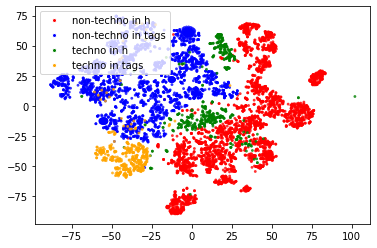

In [18]:
visualize_h_tags(isJE=True)

visualize h and tags with JE
(598, 2048)
(3734, 2048)


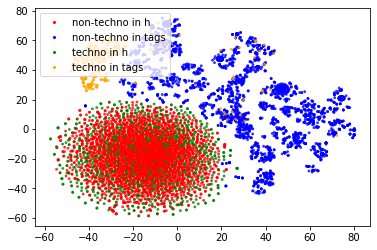

In [19]:
visualize_h_tags(isJE=False)

visualize h
(598, 1024)
(3734, 1024)


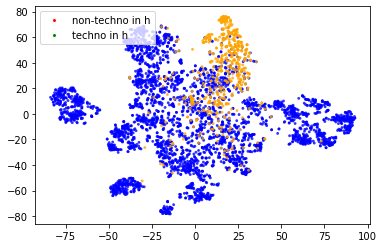

In [24]:
visualize_h(isJE=True)

visualize h
(598, 2048)
(3734, 2048)


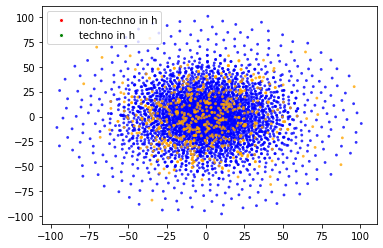

In [25]:
visualize_h(isJE=False)

visualize h
(598, 50)
(3734, 50)


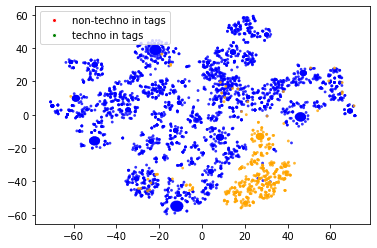

In [28]:
visualize_tags()